In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network, detect_extrema_dot_motion
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [4]:
def make_churchland_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.032, 0.064, 0.128, 0.256, 0.512, 0.768]
    dfs = []
    columns = ('type', 'trial', 'nActions', 'coherence', 'RT', 'accuracy')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            for c, coherence in enumerate(coherences):
                # select preferred direction (0) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                if c >= len(emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time']): continue  # empty data
                dat = emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(dat[trial]['rt']) != float: continue  # empty data, skip
                    RT = int(dat[trial]['rt'])
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=1/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    dfs.append(pd.DataFrame([['monkey', trial, nActions, 100*coherence, RT/1000, accuracy]], columns=columns))

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_behavior.pkl")

In [ ]:
# make_churchland_behavior_dataframe()

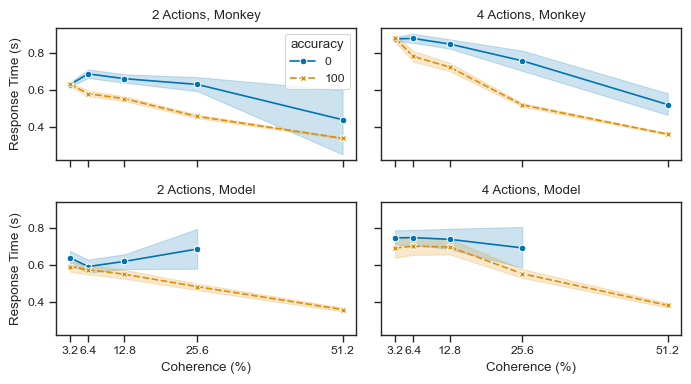

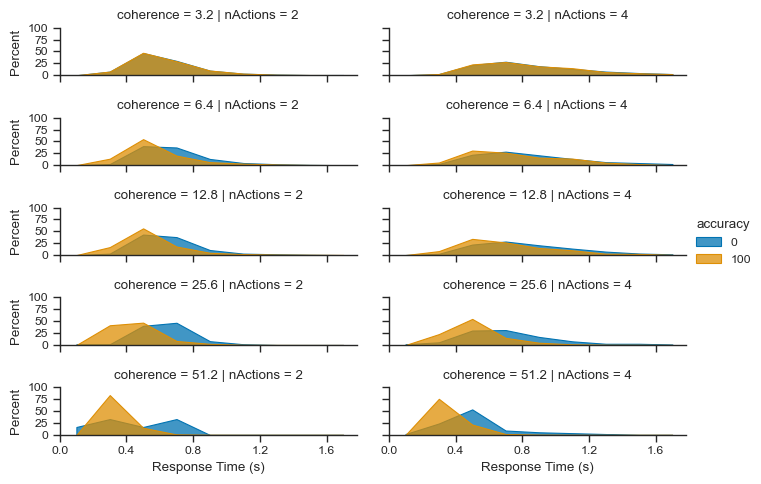

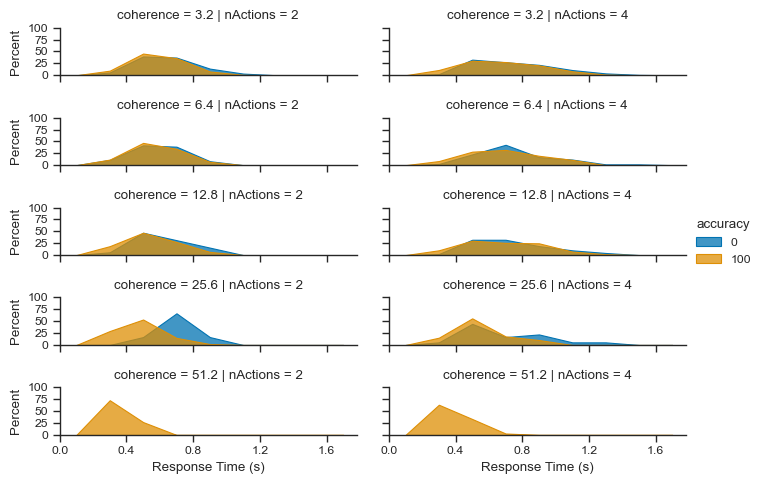

In [36]:
error=('ci', 95)
estimator=np.mean
coherences=[0.032, 0.064, 0.128, 0.256, 0.512]  # , 0.768
cohs = 100*np.array(coherences)
bins=np.arange(0.0, 2, 0.2)
name = "dec14full"


# churchland = pd.read_pickle('data/churchland2008_behavior.pkl').query("nActions==@nActions")
churchland = pd.read_pickle('data/churchland2008_behavior.pkl').query("coherence in @cohs")
simulated = pd.read_pickle(f"data/{name}.pkl").query("coherence in @cohs")

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
sns.lineplot(data=churchland.query("nActions==2"), x='coherence', y='RT', hue='accuracy', style='accuracy', palette=palette[:2], markers=True, ax=axes[0][0],
             errorbar=error, estimator=estimator)
sns.lineplot(data=churchland.query("nActions==4"), x='coherence', y='RT', hue='accuracy', style='accuracy', palette=palette[:2], markers=True, ax=axes[0][1],
             errorbar=error, estimator=estimator)
sns.lineplot(data=simulated.query("nActions==2"), x='coherence', y='RT', hue='accuracy', style='accuracy', palette=palette[:2], markers=True, ax=axes[1][0],
             errorbar=error, estimator=estimator)
sns.lineplot(data=simulated.query("nActions==4"), x='coherence', y='RT', hue='accuracy', style='accuracy', palette=palette[:2], markers=True, ax=axes[1][1],
             errorbar=error, estimator=estimator)
axes[0][0].set(ylabel="Response Time (s)", title="2 Actions, Monkey")
axes[0][1].set(title="4 Actions, Monkey")
axes[1][0].set(title="2 Actions, Model")
axes[1][1].set(title="4 Actions, Model")
# axes[0][0].legend(ncols=2)
# axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
# axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
# axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
axes[1][0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
axes[1][1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
axes[0][1].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
plt.tight_layout()
# fig.savefig(f"plots/compare_churchland_model2.svg")
# fig.savefig(f"plots/compare_churchland_model2.png", dpi=600)

fig = sns.FacetGrid(churchland, col='nActions', row="coherence", hue='accuracy', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
fig.set_xlabels("Response Time (s)")
fig.set(xticks=bins[::2])
fig.set(yticks=[0,25,50,75,100])
fig.add_legend()

fig = sns.FacetGrid(simulated, col='nActions', row="coherence", hue='accuracy', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
fig.set_xlabels("Response Time (s)")
fig.set(xticks=bins[::2])
fig.set(yticks=[0,25,50,75,100])
fig.add_legend()
# fig.savefig(f"plots/churchland_compare2_RTs.svg")
# fig.savefig(f"plots/churchland_compare2_RTs.png", dpi=600)

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_error(simulated, empirical, coherences, bins=np.arange(0.0, 2.0, 0.2)):
    total_loss = 0
    for nActions in [2,4]:
        chis = []
        accs = []
        for coherence in coherences:
            rts_sim = simulated.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            accs_sim = simulated.query("nActions==@nActions & coherence==@coherence")['accuracy'].to_numpy()
            accs_emp = empirical.query("nActions==@nActions & coherence==@coherence")['accuracy'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            acc = np.abs(np.mean(accs_sim) - np.mean(accs_emp))
            chis.append(chi)
            accs.append(acc)
        # print('nActions', nActions, f'chi2 {np.mean(chis):.3}', f'accuracy {np.mean(accs):.3}')
        print('nActions', nActions, f'chi2 {np.sum(chis):.3}', f'accuracy {np.sum(accs):.3}')

In [3]:
def single_trial(
        coherence,
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(70, 100),
        rA=4.0,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=3,
        name="multiple_alternatives"):


    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7, 2.5)))
    for n, nActions in enumerate([2, 4]):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=network_seed+perception_seed, max_rates=max_rates,
                            ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
            correct = 1 if choice==net.inputs.correct else 0

        for a in range(nActions):
            axes[n].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
        for a in range(nActions):
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[n].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
        axes[n].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), color="red", linestyle=":")
        axes[n].set(xlabel="Time (s)", title=f"{nActions} Actions")
        axes[n].legend(loc='upper left', ncol=2)
    axes[0].set(ylabel=r"$\mathbf{V}(t)$")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

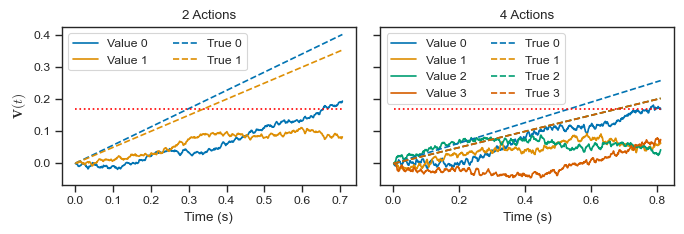

In [57]:
single_trial(coherence=0.064, ramp=1.07, relative=0.61, threshold=0.17, trials=100,
                nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03,
                perception_seed=2, name="dynamics6")

In [2]:
def simulate(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        # nActions=2,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(70, 100),
        rA=4.0,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        estimator=np.mean,
        tmax=3,
        bins=np.arange(0.0, 2, 0.2),
        name="churchland_sim_behavior"):
    
    cohs = 100*np.array(coherences)
    if not load:
        columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
        dfs = []
        for nActions in [2, 4]:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                # print(f"coherence {coherence}")
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                    dfs.append(pd.DataFrame([['model', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        # data.to_pickle(f"data/{name}_{nActions}.pkl")
        data.to_pickle(f"data/{name}.pkl")
    else:
        # data = pd.read_pickle(f"data/{name}_{nActions}.pkl")
        data = pd.read_pickle(f"data/{name}.pkl")

    # churchland = pd.read_pickle('data/churchland2008_behavior.pkl').query("nActions==@nActions")
    churchland = pd.read_pickle('data/churchland2008_behavior.pkl')
    combined = pd.concat([churchland, data])
    get_error(combined.query("type=='model'"), combined.query("type=='monkey'"), cohs, bins=bins)

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='nActions', style='type', palette=palette[:2], markers=True, ax=axes[0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='nActions', style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    # axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_churchland_model2.svg")
    fig.savefig(f"plots/compare_churchland_model2.png", dpi=600)

    fig = sns.FacetGrid(combined, col='nActions', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/churchland_compare2_RTs.svg")
    fig.savefig(f"plots/churchland_compare2_RTs.png", dpi=600)

In [11]:
def simulate_extrema(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        sigma=0.3,
        threshold=1.0,
        tiebreaker='largest',
        nd_mean=0,
        nd_sigma=0,
        tmax=3,
        trials=200,
        perception_seed=0,
        network_seed=0,
        dt_sample=0.01,
        load=False,
        name='churchland_extrema'):
    
    rng = np.random.RandomState(seed=network_seed)
    cohs = 100*np.array(coherences)
    if not load:
        columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
        dfs = []
        for n, nActions in enumerate([2, 4]):
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    choice, RT = detect_extrema_dot_motion(inputs, threshold, tiebreaker, tmax=tmax, seed=network_seed)
                    correct = True if choice==inputs.correct else False
                    ndt = rng.normal(nd_mean, nd_sigma)
                    ndt = np.max([0, ndt])
                    RT += ndt
                    # print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                    dfs.append(pd.DataFrame([['extrema', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

In [63]:
def simulate_extrema_separate(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        sigmas=[0.3, 0,3],
        thresholds=[1.0, 1.0],
        tiebreakers=['largest', 'largest'],
        dt_samples=[0.01, 0.01],
        nd_means=[0,0],
        nd_sigmas=[0,0],
        tmax=3,
        trials=200,
        perception_seed=0,
        network_seed=0,
        load=False,
        name='churchland_extrema_separate'):
    
    cohs = 100*np.array(coherences)
    rng = np.random.RandomState(seed=network_seed)
    if not load:
        columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
        dfs = []
        for n, nActions in enumerate([2, 4]):
            threshold = thresholds[n]
            dt_sample = dt_samples[n]
            tiebreaker = tiebreakers[n]
            sigma = sigmas[n]
            nd_mean = nd_means[n]
            nd_sigma = nd_sigmas[n]
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    choice, RT = detect_extrema_dot_motion(inputs, threshold, tiebreaker, tmax=tmax, seed=network_seed)
                    correct = True if choice==inputs.correct else False
                    ndt = rng.normal(nd_mean, nd_sigma)
                    ndt = np.max([0, ndt])
                    RT += ndt  # add non-decision time to model's RT
                    # print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                    dfs.append(pd.DataFrame([['extrema', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

In [8]:
def plot_sat(simfile, extrfile, empfile="churchland2008_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 2, 0.2)):

    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl')
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()
    # get_error(combined.query("type=='model'"), combined.query("type=='monkey'"), cohs, bins=bins)

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 6)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style='nActions', palette=palette[:3], markers=True, ax=axes[0],
                 errorbar=error, estimator=estimator, hue_order=['monkey', 'model', 'extrema'])
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='type', style='nActions', palette=palette[:3], markers=True, ax=axes[1],
                 hue_order=['monkey', 'model', 'extrema'])
    axes[0].set(ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    # axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_sat.svg")
    fig.savefig(f"plots/churchland_sat.png", dpi=600)

    fig = sns.FacetGrid(combined, col='nActions', row="coherence", hue='type', palette=palette[:3], height=1.5, aspect=3,
                        sharex=True, legend_out=True, hue_order=['monkey', 'model', 'extrema'])
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/churchland_RTs.svg")
    fig.savefig(f"plots/churchland_RTs.png", dpi=600)

## Simulate (behavior)

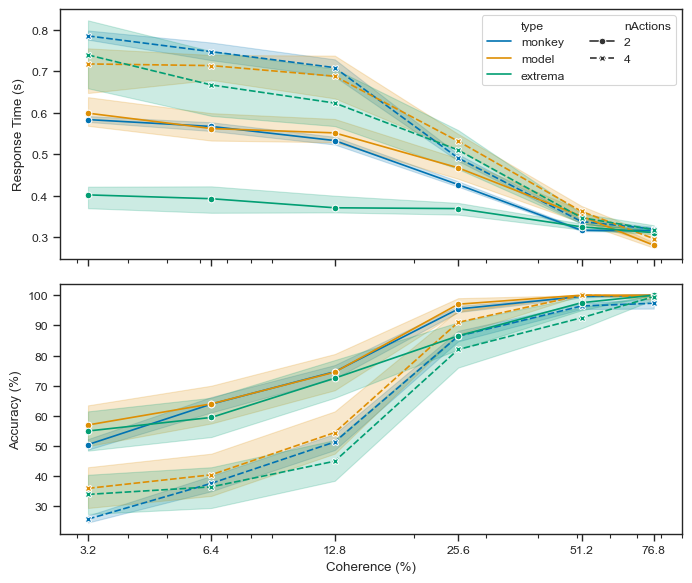

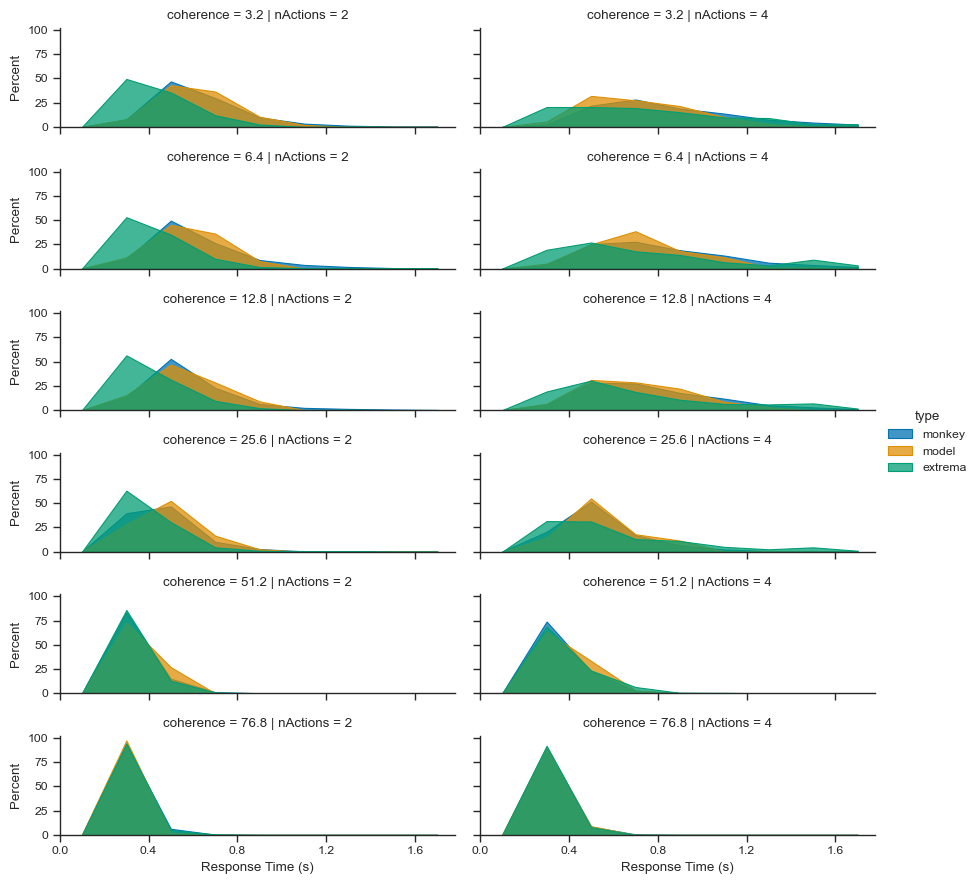

In [12]:
simulate_extrema(threshold=1.01, sigma=0.3, dt_sample=0.014, tiebreaker='random', nd_mean=0.29, nd_sigma=0.02)
plot_sat("dec14full", "churchland_extrema", "churchland2008_behavior")

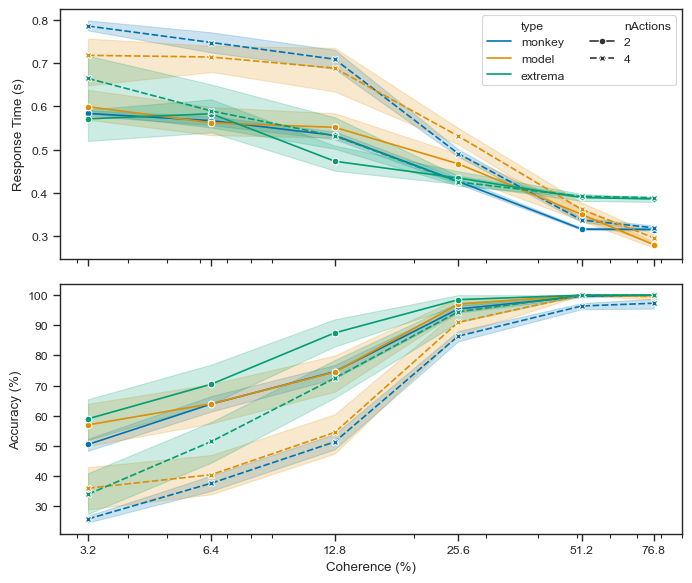

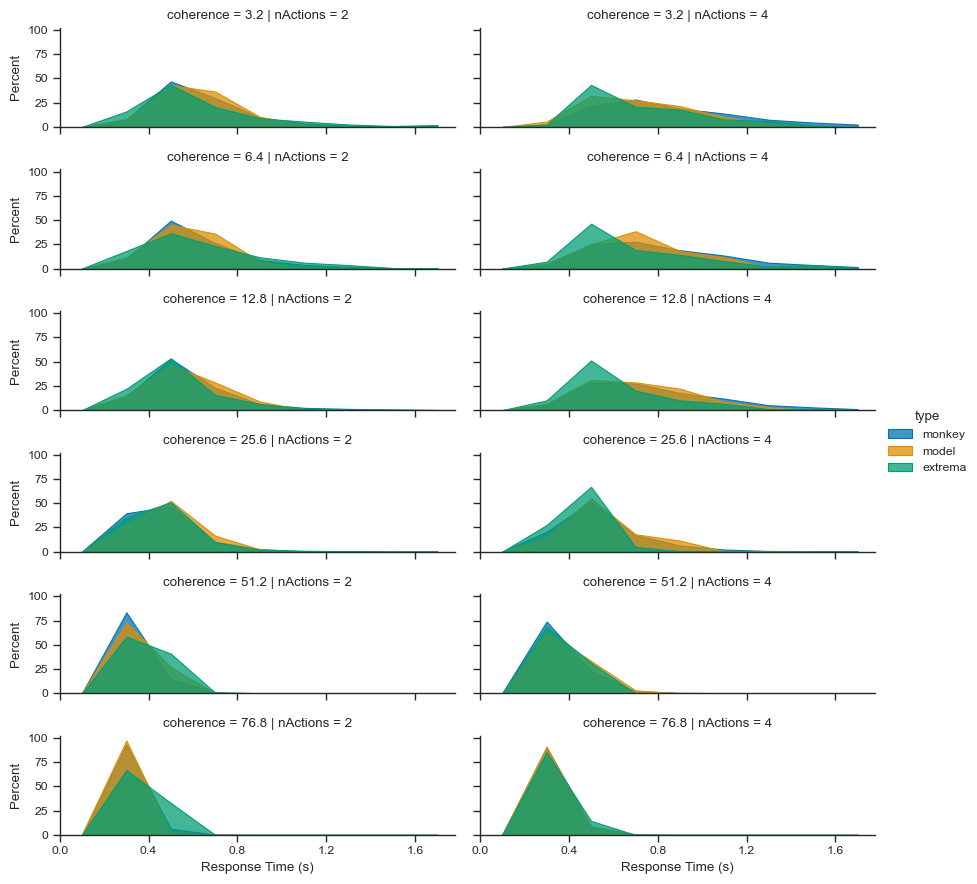

In [71]:
simulate_extrema_separate(
    trials=200,
    thresholds=[0.67, 0.52],
    dt_samples=[0.06, 0.027],
    sigmas=[0.13, 0.13],
    nd_means=[0.38, 0.39],
    nd_sigmas=[0.04, 0.01],
    tiebreakers=['largest', 'largest'])
plot_sat("dec14full", "churchland_extrema_separate", "churchland2008_behavior")

nActions 2 chi2 0.304 accuracy 8.72
nActions 4 chi2 0.356 accuracy 26.5


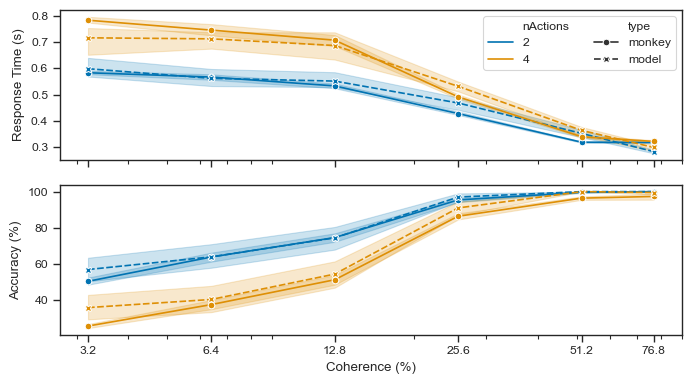

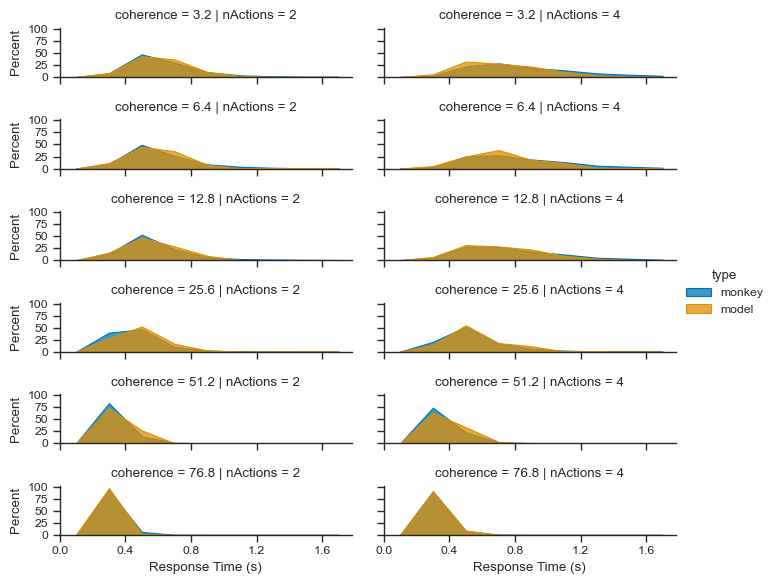

In [35]:
simulate(ramp=1.48, relative=0.59, threshold=0.22, trials=200, name="dec14full", estimator=np.median,
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=True)

# Firing Rate Experiments

In [13]:
def rate_experiment(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        nAs=[2,4],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(100, 200),
        rA=4.0,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=3,
        t0=0.15,
        t1=0.3,
        t2=-0.3,
        name="default"):
    
    if not load:
        dfs = []
        for nActions in nAs:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                inputs.create(coherence=coherence)
                for trial in range(trials):
                    net = build_network(inputs, nActions=nActions, seed=trial,
                                        ramp=ramp, threshold=threshold, relative=relative,
                                        nNeurons=nNeurons, rA=rA, max_rates=max_rates, probe_spikes=True)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    print(f"trial {trial}, coherence {coherence}, nActions {nActions}, correct {correct}, RT {RT}")
                    aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,net.inputs.correct] > 0.9)
                    for neuron in aligned_neuron_idx:
                        df = pd.DataFrame()
                        df['time'] = sim.trange()
                        df['time2'] = -1*sim.trange()[::-1]
                        df['nActions'] =  nActions*np.ones_like(sim.trange())
                        df['coherence'] =  100*coherence*np.ones_like(sim.trange())
                        df['trial'] =  trial*np.ones_like(sim.trange())
                        df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                        df['RT'] = RT*np.ones_like(sim.trange())
                        df['neuron'] = neuron*np.ones_like(sim.trange())
                        df['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()
                        df['evidence'] = sim.data[net.pAccumulator][:,net.inputs.correct].ravel()
                        df['value'] = sim.data[net.pValue][:,net.inputs.correct].ravel()
                        dfs.append(df)
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}_firing_rates.pkl")
    else:
        data = pd.read_pickle(f"data/{name}_firing_rates.pkl")

    data_start = data.query("time>@t0 & time<@t1")
    data_end = data.query("time2>@t2")
    # palette2 = sns.color_palette("viridis", len(data['coherence'].unique()))
    palette2 = palette[:len(coherences)]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    sns.lineplot(data=data_start, x='time', y='firing rate', hue="coherence", style='nActions', palette=palette2, ax=axes[0])
    sns.lineplot(data=data_end, x='time2', y='firing rate', hue="coherence", style='nActions', palette=palette2, ax=axes[1])
    axes[0].set(xlabel="Time After Stimulus (s)", ylabel="Firing Rate (Hz)", title=f"Ramping Activities")
    axes[1].set(xlabel="Time Before Response (s)", ylabel=None, title=f"Converging Activities")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_firing_rates.svg")
    fig.savefig(f"plots/{name}_firing_rates.png", dpi=600)

## Simulate (rates)

In [ ]:
rate_experiment(coherences=[0.032, 0.256], ramp=1.07, relative=0.61, threshold=0.17, name="dec13a",
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, trials=10, load=False)

## Churchland dataframe

In [29]:
def make_churchland_firing_dataframe():
    # convert original matlab files into a single pandas dataframe
    # coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'trial', 'neuron', 'accuracy', 'time', 'time2', 'firing rate')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times
    pref = 1  # preferred direction 

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            nCoherences = len(emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'])
            for c in range(nCoherences):
                # select preferred direction (pref) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                dat = emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    if type(dat[trial]['rt'])!=float: continue
                    RT = int(dat[trial]['rt'])
                    coherence = float(dat[trial]['coh']) / 10
                    spike_times = dat[trial]['dots']
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(spike_times)!=np.ndarray or len(spike_times)==0:  continue  # skip empty data
                    spike_times = np.array(dat[trial]['dots']).astype(int)  # remove sub-ms precision in spike times
                    tstart = spike_times[0]
                    tend = spike_times[-1]+1
                    times = np.arange(tstart, tend)/1000  # time relative to stimulus onset, in seconds
                    times2 = np.arange(tstart-tend, 0)/1000  # time relative to response, in seconds
                    spike_array = np.zeros_like(times)
                    spike_array[spike_times-tstart] = 1  # put a value of 1 at the index of every spike time
                    firing_rates = filter.filt(1000*spike_array)  # compute firing rate in spikes/second (Hz) by filtering with lowpass filter
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=100/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    df = pd.DataFrame()
                    df['nActions'] = nActions*np.ones_like(times)
                    df['coherence'] = coherence*np.ones_like(times)
                    df['trial'] = trial*np.ones_like(times)
                    df['neuron'] = neuron*np.ones_like(times)
                    df['RT'] = RT*np.ones_like(times)
                    df['accuracy'] = accuracy*np.ones_like(times)
                    df['nActions'] = nActions*np.ones_like(times)
                    df['time'] = times
                    df['time2'] = times2
                    df['firing rate'] = firing_rates
                    dfs.append(df)

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_firing.pkl")

In [ ]:
# Warning: makes a 2GB pickle file
# churchland_firing = make_churchland_firing_dataframe()

In [18]:
def plot_churchland_firing(coherences=[0.032, 0.256], t0=0.15, t1=0.4, t2=-0.4, t3=-0.05):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    coh = 100*np.array(coherences)
    subdata2_start = churchland.query("nActions==2 & time>@t0 & time<@t1 & coherence in @coh & accuracy==100")
    subdata2_end = churchland.query("nActions==2 & time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100")
    subdata4_start = churchland.query("nActions==4 & time>@t0 & time<@t1 & coherence in @coh & accuracy==100")
    subdata4_end = churchland.query("nActions==4 & time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100")
    del(churchland)

    palette2 = palette[:len(coherences)]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)), sharey=True, sharex='col')
    sns.lineplot(data=subdata2_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=subdata2_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=subdata4_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=subdata4_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (2 actions)')
    axes[0][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (2 actions)')
    axes[1][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (4 actions)')
    axes[1][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (4 actions)')
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_firing.svg")
    fig.savefig(f"plots/churchland_firing.png", dpi=600)

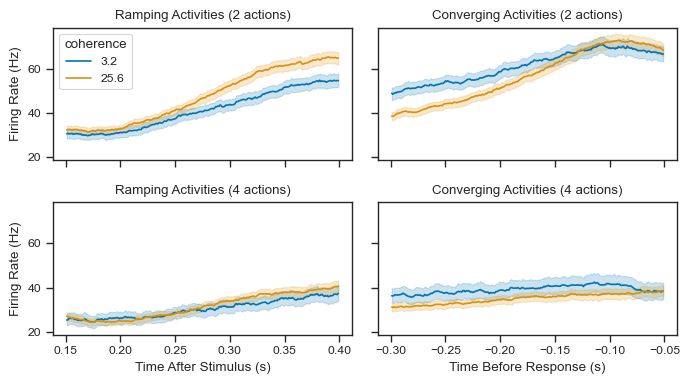

In [39]:
plot_churchland_firing()

## Compare

In [58]:
def compare_firing(sim, coherences=[0.032, 0.256], t0=0.1, t1=0.4, t2=-0.3, t3=-0.01):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    coh = 100*np.array(coherences)
    emp_start = churchland.query("time>@t0 & time<@t1 & coherence in @coh & accuracy==100 & nActions==2")
    emp_end = churchland.query("time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100 & nActions==2")
    del(churchland)
    sim = pd.read_pickle(f"data/{sim}_firing_rates.pkl")
    sim_start = sim.query("time>@t0 & time<@t1")
    sim_end = sim.query("time2>@t2 & time2<@t3")

    a = ['monkey' for _ in range(emp_start.shape[0])]
    b = ['model' for _ in range(sim_start.shape[0])]
    c = ['monkey' for _ in range(emp_end.shape[0])]
    d = ['model' for _ in range(sim_end.shape[0])]
    emp_start.insert(0, 'type', a)
    sim_start.insert(0, 'type', b)
    emp_end.insert(0, 'type', c)
    sim_end.insert(0, 'type', d)
    combined_start = pd.concat([emp_start, sim_start], ignore_index=True)
    combined_end = pd.concat([emp_end, sim_end], ignore_index=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=False)
    sns.lineplot(data=combined_start, x='time', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[0])
    sns.lineplot(data=combined_end, x='time2', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities')  # , xlim=[0.15, 0.35])
    axes[1].set(xlabel='Time Before Response (s)', title=f'Converging Activities')  # , xlim=[-0.35, -0.05])
    axes[0].legend(loc="upper left", ncols=2)
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_churchland_firing2.svg")
    fig.savefig(f"plots/compare_churchland_firing2.png", dpi=600)

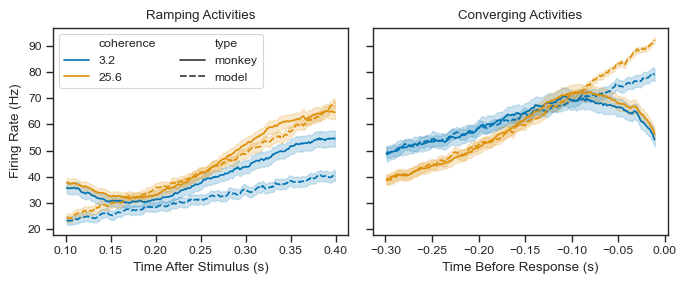

In [63]:
compare_firing("dec13a")